Script for processing the multispectral images (.tif), after cutting the plots from the orthomosaics using the "cut_plots_using_shapefile.sh" script.

In [1]:
# Import libraries
import os
import numpy as np
import cv2
from osgeo import gdal
import matplotlib.pyplot as plt
import random
%matplotlib inline
from glob import glob

# Rotate the plot

Plot images are likely to be skewed when cut from the orthomosaic, so the scrip below is used to change the images from a diagonal to vertical position.

General processing steps:
* write a bounding box that covers the plot
* rotate the crop (use 0 as padding to achieve a standardised size)
* cut the exceding edges of the image

In [2]:
def threshold_image(image):
    # The function uses thresholding to find the boundaries of the plot
    thresh = cv2.adaptiveThreshold(image, 
                                   255, 
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 
                                   11, 2)
    # Get the coordenates for the bounding box
    coords = np.column_stack(np.where(thresh == 0)) # pixels = 0 mark the plot contour
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] # find the rectangle with min area passing through the points array

    # If the images are turning vertical when I want horizontal or vice-versa
    # just change the < > signal to get the opposite 
    if angle < -50:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Rotation matrix for the image
    (h, w) = image.shape
    center = (w // 2, h // 2)
    # calculate the affine matrix of 2D rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0) 
    
    return angle, coords, M, rect

In [11]:
def rotate_msi(img_path, img_out=None):
    # Get MSI file
    dataset = gdal.Open(img_path)
    msi_ds = dataset.ReadAsArray() #reads tif into numpy array
    
    # Create output folder 
    if img_out is None:
        name = dataset.GetDescription()
        basename = os.path.basename(name)
        basename =  os.path.splitext(basename)[0]
        fname = os.path.dirname(name).replace('plot', 'rotated') # change depending on the file name
        if not os.path.exists(fname):
            os.mkdir(fname)
        output_path_MSI = os.path.join(fname,basename)
    else:
        output_path_MSI = img_out

    # Get one band to find the threshold  
    band = msi_ds[1].copy() # copy one band from the 5 channel numpy array
    band = (band*255).astype('uint8') # adaptivethreshold only accepts 8bit 1 channel images
    angle, coords, M, rect = threshold_image(band)

    # Define the variables for cropping based on the rectangle
    center = tuple(map(int,(rect[0][1], rect[0][0])))
    size = tuple(map(int, (rect[1][1], rect[1][0]))) 
    
    # for band in range(n_bands):
    w_rect, h_rect = size[0], size[1]
    _, h_msi, w_msi = msi_ds.shape
    n_bands = 5
    
    # Create the array object in which the cropped bands will be saved
    crop_size = (size[1], size[0], 5)
    msi_out = np.zeros(shape=crop_size, dtype='float32')

    # Process the MSI
    for band_index in range(n_bands):
        # Rotate the selected band
        input_band = msi_ds[band_index].copy()
        rotated_band = cv2.warpAffine(input_band, 
                                      M, (h_msi, w_msi),
                                      flags=cv2.INTER_NEAREST,
                                      borderMode=cv2.BORDER_CONSTANT).astype('float32')
        # normalise the reflection values by 32769 
        # which is 100% of the reflectance in micasense images
        rotated_band = (rotated_band / 32768).astype('float32') 
        
        # Crop the selected band
        cropped_band = cv2.getRectSubPix(rotated_band, (crop_size[1], crop_size[0]), center)  
        msi_out[:,:,band_index] = cropped_band # Save the band to np array
    
    np.save(output_path_MSI, msi_out) # save output file

In [7]:
# Pick a image folder and rotate all plot images in there
folders_list = glob('/data/plots/')

for folder in folders_list:
    image_files = os.listdir(folder)
    for image in image_files:
        img_path = os.path.join(folder,image)
        rotate_msi(img_path)

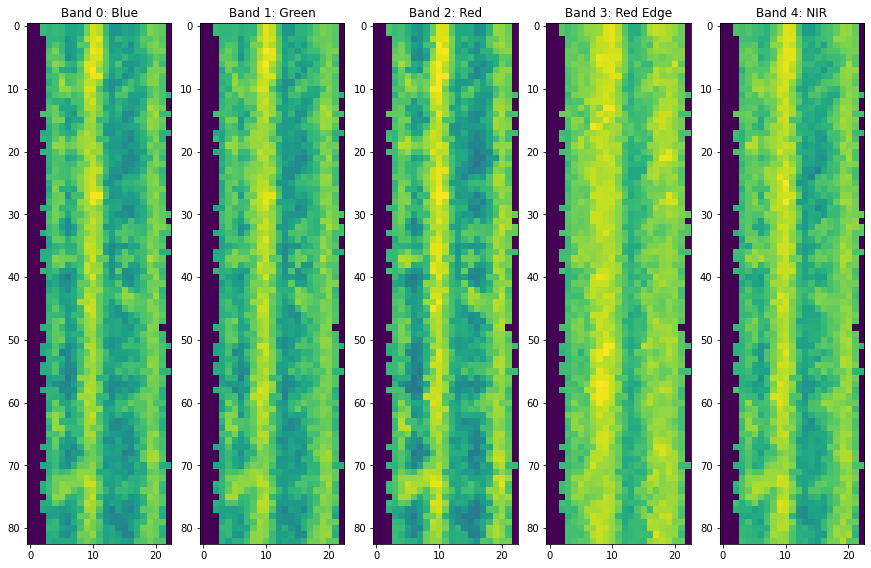

In [12]:
# Check if the images are rotated as expected
test = np.load('/data/plots/CS17-DG2F-045.npy')

fig, axs = plt.subplots(1,5, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
title = ['Blue', "Green", 'Red', 'Red Edge', 'NIR']

for i in range(5):
    axs[i].imshow(test[:,:,i])
    axs[i].set_title(f"Band {i}: {title[i]}")